# Executive Summary


Equity-derivatives desks organize listed option prices into an **implied volatility surface**: a function $\sigma_{\text{imp}}(K,T)$ (or equivalently $\sigma_{\text{imp}}(k,T)$) mapping strike $K$ and maturity $T$ to the Black–Scholes implied volatility. In practice, the surface is the desk’s common language for quoting, marking, and risk. Books are managed in vol space, Greeks are computed off the surface, and the same object feeds both exotic pricing engines and systematic (QIS) signals.

Because option quotes arrive only on a **discrete and sometimes noisy** grid of strikes and expiries, a core desk task is to reconstruct a **smooth, arbitrage-aware surface** consistent with those quotes. Static no-arbitrage requires that call prices are decreasing and convex in strike, and that total variance is non-decreasing in maturity. A fitted surface is therefore a tradable proxy for the continuous object implied by theory.

Three complementary viewpoints explain why surfaces matter:

1. **Risk-neutral distribution (Breeden–Litzenberger).**  
   For smooth, arbitrage-free European calls $C(K,T)$, the risk-neutral density of $S_T$ is recovered from strike curvature:
   $$ 
   q_T(K)=\frac{\partial^2 C(K,T)}{\partial K^2}.
   $$
   So an implied-vol surface is equivalent to a full family of risk-neutral distributions across maturities. This is why surfaces sit at the center of pricing, risk, stress testing, and tail-hedging on equity-vol desks.

2. **Dynamic consistency (Dupire local volatility).**  
   Starting from the same arbitrage-free call surface $C(K,T)$, Dupire shows there exists a unique local-vol diffusion reproducing all vanilla prices. In its simplest (zero-carry) form:
   $$
   \sigma_{\text{loc}}^2(K,T)=
   \frac{\partial_T C(K,T)}
        {\tfrac{1}{2}K^2\,\partial_{KK} C(K,T)},
   $$
   with standard carry/rate adjustments in the full formula. This links the *static* implied surface to a *dynamic* model calibrated to the market smile.

3. **Smile-consistent lattices (implied trees).**  
   In discrete time, implied-tree methods (Derman–Kani, Rubinstein) build recombining risk-neutral trees $\{S_{i,j}\}$ with state prices $\{\pi_{i,j}\}$ so that for each maturity $T_i$:
   $$
   C(K,T_i)=\sum_j \pi_{i,j}(S_{i,j}-K)^+,
   \qquad
   \sum_j \pi_{i,j}=D(T_i).
   $$
   Node values or transition probabilities are chosen so these equalities match the observed smile across strikes, producing arbitrage-free engines for exotic pricing when only vanilla smiles are quoted.

**How this notebook fits in.**  
Rather than building a full local-vol PDE or implied-tree engine, we use **SVI (Gatheral)** as a desk-standard parametric representation of per-expiry **total variance**:
$$
w(k,T)=a + b\left(\rho (k-m) + \sqrt{(k-m)^2+\sigma^2}\right),
\qquad k=\ln(K/F).
$$
SVI is popular because it fits index smiles well, is numerically stable, and makes static-arbitrage checks tractable. Our fitted SVI surface is a practical approximation to the same arbitrage-free call surface that underlies Breeden–Litzenberger densities, Dupire local vol, and implied trees.

Using the CSVs produced by the pipeline, this notebook rebuilds and interprets an **SVI-calibrated SPY volatility surface** (weekly snapshots):

1. Load stored option chains and saved SVI parameters for dates where both are available.  
2. Reconstruct forwards $F(T)$ and discount factors $D(T)$ via put–call parity, compute log-moneyness $k=\ln(K/F)$, and (when possible) market IVs via Black–Scholes inversion.  
3. Rebuild fitted smiles and a smooth surface from SVI parameters, overlaying market points where reliable.  
4. Run lightweight no-arbitrage / quality diagnostics (calendar monotonicity, total-variance positivity).  
5. Demonstrate desk use cases: ATM term structure, skew/convexity term structures, and a proxy variance-swap fair strike.

If EOD market IV inversion yields few or no valid points at some expiries (common in the wings), the surface is still built from SVI parameters and market dots are shown only where available.

The other notebooks in this repo work with *rates term-structures* and factor dynamics, while this one works with *equity-option surfaces*, as **rates are a key state variable for equity-vol surfaces**.

- **Mechanically:** in equity options, forwards and discount factors depend on the risk-free curve:
  $$ F(T)=S_0\,e^{(r-q)T}, \qquad D(T)=e^{-rT}. $$
  Even when we infer $F$ from parity, we are implicitly using the funding/dividend term-structure. Changes in rates therefore shift the *moneyness axis* $k=\ln(K/F)$ and the level of total variance used for calibration.

- **Economically:** rates summarize financial conditions. When bond yields rise or the expected path of policy changes, equity risk premia and crash-risk hedging demand typically move with them. That demand is expressed in the **level and skew** of the equity smile. In late-2024 this cross-asset channel was visible: elevated pre-election uncertainty plus shifting rate expectations lifted short-dated equity IVs, then vols collapsed once the event passed. :contentReference[oaicite:0]{index=0}

Seen together, the portfolio shows one consistent QIS workflow across asset classes:
1. start from a term-structure object (yield curve or vol surface),  
2. compress it into a low-dimensional representation (PCA factors, OU state, SVI parameters/features),  
3. model or compare its dynamics,  
4. turn outputs into pricing, hedging, or systematic signals.

That cross-asset, term-structure-first way of thinking is exactly what equity-derivatives / QIS teams look for.

## 0. Setup folder layout

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

plt.rcParams['figure.dpi'] = 130

ROOT = Path(".")        # notebook in repo root

DATA = ROOT / "data"
DATA_SURF = DATA / "surfaces"

#print("ROOT:", ROOT.resolve())
#print("DATA exists:", DATA.exists(), DATA.resolve())
#print("SURF exists:", DATA_SURF.exists(), DATA_SURF.resolve())

## 1. Discover available dates and load a working snapshot

The surface pipeline writes two types of artifacts:
- `chain_YYYY-MM-DD.csv`: option-chain snapshots with contract metadata and EOD prices.
- `svi_params_YYYY-MM-DD.csv`: per-expiry SVI fits calibrated by the pipeline.

This cell scans both folders, extracts the intersection of dates where **both** chain and SVI parameters exist, and selects the most recent common date as the working `AS_OF` snapshot. We then load:
- the raw chain (`chain_raw`) for market points and parity reconstruction, and
- the saved SVI parameters (`svi_df`) to rebuild smooth smiles/surfaces even if some market IVs are missing.

A quick printout of shapes and columns acts as a sanity check that the snapshot is complete before we rebuild model quantities.

In [2]:
chain_files = sorted(DATA.glob("chain_*.csv"))
svi_files   = sorted(DATA_SURF.glob("svi_params_*.csv"))

def dates_from(files, prefix):
    out = set()
    for p in files:
        stem = p.stem
        if stem.startswith(prefix):
            d = stem.split("_")[-1]
            if len(d) == 10 and d[4]=="-" and d[7]=="-":
                out.add(d)
    return out

chain_dates = dates_from(chain_files, "chain")
svi_dates   = dates_from(svi_files, "svi_params")
common_dates = sorted(chain_dates.intersection(svi_dates))

print("Dates with chains:", sorted(chain_dates))
print("Dates with SVI:", sorted(svi_dates))
print("COMMON dates:", common_dates)

AS_OF = common_dates[-1] if common_dates else None
print("Chosen AS_OF:", AS_OF)

def load_chain(as_of):
    for p in [DATA/f"chain_final_{as_of}.csv", DATA/f"chain_{as_of}.csv"]:
        if p.exists():
            return pd.read_csv(p, low_memory=False)
    return pd.DataFrame()

def load_svi_params(as_of):
    p = DATA_SURF / f"svi_params_{as_of}.csv"
    if not p.exists():
        raise FileNotFoundError(p)
    return pd.read_csv(p, parse_dates=["expiry"])

chain_raw = load_chain(AS_OF)
svi_df = load_svi_params(AS_OF)

print("Loaded chain shape:", chain_raw.shape)
print("Loaded svi_df shape:", svi_df.shape)
print(chain_raw.columns.tolist())
chain_raw.head(), svi_df.head()

Dates with chains: ['2024-06-03', '2024-11-01', '2024-11-08', '2024-11-15', '2024-11-22', '2024-11-29', '2024-12-06', '2024-12-13', '2024-12-20', '2024-12-27', '2025-01-03', '2025-01-10', '2025-01-17', '2025-01-24', '2025-01-31', '2025-02-07']
Dates with SVI: ['2024-06-03', '2024-11-01', '2024-11-08', '2024-11-15', '2024-11-22', '2024-11-29', '2024-12-06', '2024-12-13', '2024-12-20', '2024-12-27', '2025-01-03', '2025-01-10', '2025-01-17', '2025-01-24', '2025-01-31', '2025-02-07']
COMMON dates: ['2024-06-03', '2024-11-01', '2024-11-08', '2024-11-15', '2024-11-22', '2024-11-29', '2024-12-06', '2024-12-13', '2024-12-20', '2024-12-27', '2025-01-03', '2025-01-10', '2025-01-17', '2025-01-24', '2025-01-31', '2025-02-07']
Chosen AS_OF: 2025-02-07
Loaded chain shape: (156, 22)
Loaded svi_df shape: (6, 7)
['cfi', 'contract_type', 'exercise_style', 'expiration_date', 'primary_exchange', 'shares_per_contract', 'strike_price', 'option_symbol', 'underlying_ticker', 'expiry', 'strike', 'cp', 'Tdays',

(      cfi contract_type exercise_style expiration_date primary_exchange  \
 0  OCASPS          call       american      2025-02-14             BATO   
 1  OPASPS           put       american      2025-02-14             BATO   
 2  OCASPS          call       american      2025-02-14             BATO   
 3  OPASPS           put       american      2025-02-14             BATO   
 4  OCASPS          call       american      2025-02-14             BATO   
 
    shares_per_contract  strike_price         option_symbol underlying_ticker  \
 0                  100         525.0  O:SPY250214C00525000               SPY   
 1                  100         525.0  O:SPY250214P00525000               SPY   
 2                  100         530.0  O:SPY250214C00530000               SPY   
 3                  100         530.0  O:SPY250214P00530000               SPY   
 4                  100         535.0  O:SPY250214C00535000               SPY   
 
        expiry  ...  Tdays       mny  atm_dist        

## 2. Rebuild forwards/discounts and (if possible) market IVs

The raw chain file contains strikes, expiries, call/put flags, and EOD prices, but it does **not** reliably store:
- forward price $F(T)$,
- discount factor $D(T)$,
- time-to-maturity $T$ in years,
- market implied volatility $\sigma_{\text{imp}}$,
- log-moneyness $k=\ln(K/F)$,
- total variance $w=\sigma_{\text{imp}}^2T$.

We reconstruct these in three steps:

1. **Standardize columns and compute maturity.**  
   We harmonize naming (`expiry`, `strike`, `cp`, `mid`) and compute  
   $$T = \frac{\text{days to expiry}}{365}.$$

2. **Infer $(F,D)$ by put–call parity.**  
   For a fixed expiry, parity gives  
   $$ C(K,T)-P(K,T)=D(T)\,(F(T)-K). $$
   Regressing $C-P$ on $K$ across matched strikes yields slope $-D(T)$ and intercept $D(T)F(T)$.  
   If parity is too sparse for an expiry, we fall back to $F=$ median strike and $D=1$.

3. **Invert Black–Scholes to get market IVs.**  
   For each option we solve for $\sigma$ such that  
   $$ \text{BS}(cp, F, K, T, D, \sigma) = \text{mid price}. $$
   Root-finding is guarded by no-arbitrage bounds so that illiquid or inconsistent quotes return `NaN`.

Finally we compute
$$k=\ln(K/F), \qquad w=\sigma_{\text{imp}}^2T.$$

Robust v2 keeps *all* contracts in `chain_all` for defining the $k$-range, while smiles use the market-IV subset `chain_mkt` only when IV inversion succeeds.


In [3]:
AS_OF_DT = pd.to_datetime(AS_OF)
chain_all = chain_raw.copy()

# --- standardize columns ---
if "expiry" not in chain_all.columns and "expiration_date" in chain_all.columns:
    chain_all["expiry"] = chain_all["expiration_date"]
chain_all["expiry"] = pd.to_datetime(chain_all["expiry"], errors="coerce")

if "strike" not in chain_all.columns and "strike_price" in chain_all.columns:
    chain_all["strike"] = chain_all["strike_price"]
chain_all["strike"] = pd.to_numeric(chain_all["strike"], errors="coerce")

if "cp" not in chain_all.columns and "contract_type" in chain_all.columns:
    chain_all["cp"] = chain_all["contract_type"].astype(str).str.upper().str[0]
chain_all["cp"] = chain_all["cp"].astype(str).str.upper().str[0]

if "mid" not in chain_all.columns:
    chain_all["mid"] = chain_all.get("close", np.nan)
chain_all["mid"] = pd.to_numeric(chain_all["mid"], errors="coerce")

chain_all = chain_all.dropna(subset=["expiry","strike","cp"]).copy()

# maturity in years
chain_all["T"] = (chain_all["expiry"] - AS_OF_DT).dt.days / 365.0
chain_all = chain_all[chain_all["T"] > 0].copy()

# --- parity forward inference ---
def infer_forward_parity(sub):
    sub = sub[np.isfinite(sub["mid"]) & (sub["mid"] > 0)]
    c = sub[sub["cp"]=="C"][["strike","mid"]].rename(columns={"mid":"C"})
    p = sub[sub["cp"]=="P"][["strike","mid"]].rename(columns={"mid":"P"})
    m = c.merge(p, on="strike", how="inner").dropna()
    if len(m) < 2:
        return np.nan, np.nan
    K = m["strike"].values
    y = (m["C"] - m["P"]).values
    beta, alpha = np.polyfit(K, y, 1)
    D = -beta
    F = alpha/D if D > 0 else np.nan
    return F, D

fwds, discs = {}, {}
for exp, sub in chain_all.groupby("expiry"):
    F, D = infer_forward_parity(sub)
    fwds[exp]  = F
    discs[exp] = D

chain_all["F"] = chain_all["expiry"].map(fwds)
chain_all["D"] = chain_all["expiry"].map(discs)

# fallback if parity failed
bad = chain_all["F"].isna() | chain_all["D"].isna()
if bad.any():
    for exp, sub in chain_all[bad].groupby("expiry"):
        chain_all.loc[chain_all["expiry"]==exp, "F"] = np.nanmedian(sub["strike"])
        chain_all.loc[chain_all["expiry"]==exp, "D"] = 1.0

for col in ["F","D","T","strike","mid"]:
    chain_all[col] = pd.to_numeric(chain_all[col], errors="coerce")
chain_all["D"] = chain_all["D"].clip(lower=1e-6, upper=1.0)

# --- BS forward pricer + safe IV inversion ---
def bs_price(cp, F, K, T, D, vol):
    sig = vol*np.sqrt(T)
    if sig < 1e-12:
        return D*max(F-K,0.0) if cp=="C" else D*max(K-F,0.0)
    d1 = (np.log(F/K) + 0.5*sig**2)/sig
    d2 = d1 - sig
    if cp=="C":
        return D*(F*norm.cdf(d1) - K*norm.cdf(d2))
    return D*(K*norm.cdf(-d2) - F*norm.cdf(-d1))

def bs_bounds(cp, F, K, T, D):
    intrinsic = D*max(F-K,0.0) if cp=="C" else D*max(K-F,0.0)
    upper = D*F if cp=="C" else D*K
    return intrinsic, upper

def implied_vol_scalar(cp, price, F, K, T, D):
    try:
        cp = str(cp).upper()[0]
        price = float(price); F=float(F); K=float(K); T=float(T); D=float(D)
    except Exception:
        return np.nan
    if price <= 0 or T <= 0 or F <= 0 or K <= 0 or D <= 0:
        return np.nan
    lo, hi = bs_bounds(cp,F,K,T,D)
    if not (lo-1e-8 <= price <= hi+1e-8):
        return np.nan
    f = lambda v: bs_price(cp,F,K,T,D,v) - price
    try:
        return brentq(f, 1e-6, 5.0, maxiter=200)
    except Exception:
        return np.nan

chain_all["iv_fit"] = [
    implied_vol_scalar(r.cp, r.mid, r.F, r.strike, r.T, r.D)
    for _, r in chain_all.iterrows()
]

# keep a market-only subset for scatter
chain_mkt = chain_all.dropna(subset=["iv_fit"]).copy()

# k and w for the full chain (even if iv missing)
chain_all["k"] = np.log(chain_all["strike"] / chain_all["F"])
chain_all["w"] = chain_all["iv_fit"]**2 * chain_all["T"]

print("Rows (all):", chain_all.shape)
print("Rows with market IV:", chain_mkt.shape)
print("Market IV count:", chain_mkt["iv_fit"].notna().sum())
print("k-range (all):", (chain_all["k"].min(), chain_all["k"].max()))

Rows (all): (156, 28)
Rows with market IV: (0, 26)
Market IV count: 0
k-range (all): (-0.13827579516258967, 0.13987399347057475)


## 3. SVI helpers and parameter mapping

SVI models per-expiry **total variance** as
$$
w(k,T)=a + b\Big(\rho (k-m)+\sqrt{(k-m)^2+\sigma^2}\Big),
\quad k=\ln(K/F).
$$

- `svi_raw` implements this $w(k,T)$ formula.
- `svi_iv` converts total variance back to implied vol via
  $$ \sigma_{\text{SVI}}(k,T)=\sqrt{\frac{w(k,T)}{T}}. $$

We then build a dictionary `params_by_exp` mapping each expiry to its calibrated
$(a,b,\rho,m,\sigma)$ vector, and compute the maturity $T$ for each expiry from
its calendar distance to `AS_OF`.  
This allows us to rebuild smooth smiles and surfaces entirely from saved parameters,
even if market IVs are missing for some strikes.


In [4]:
def svi_raw(k, a, b, rho, m, sig):
    k = np.asarray(k, float)
    return a + b*(rho*(k-m) + np.sqrt((k-m)**2 + sig**2))

def svi_iv(k, T, params):
    a,b,rho,m,sig = params
    w = svi_raw(k, a,b,rho,m,sig)
    return np.sqrt(np.maximum(w, 1e-12)/T)

params_by_exp = {
    row.expiry: row[["a","b","rho","m","sig"]].to_numpy(float)
    for _, row in svi_df.iterrows()
}

# compute T per expiry from svi_df
svi_df["T"] = (svi_df["expiry"] - AS_OF_DT).dt.days / 365.0
svi_df = svi_df[svi_df["T"]>0].copy()

## 4. Smiles: SVI fit with market dots when available

For each expiry we plot the fitted SVI smile $\sigma_{\text{SVI}}(k,T)$ on a dense
$k$-grid, and overlay market implied-vol points when IV inversion is reliable.

A key diagnostic is **shape**:
equity index options typically exhibit a *left-skewed smirk* — higher IV for negative $k$
(OTM puts / crash protection), a trough near ATM, and a gentler right wing.

Earlier in the build, most smiles looked almost linear as the plotted $k$-range
was too narrow and/or wing quotes were missing. Using a robust grid choice,
the smiles display the expected **convex smirk**: steep left tail, smooth curvature
through ATM, and a mild right-wing uplift.  
Where no market dots appear, this reflects sparse or inconsistent EOD prices, not a
failure of the SVI fit — the surface is still well-defined from parameters.

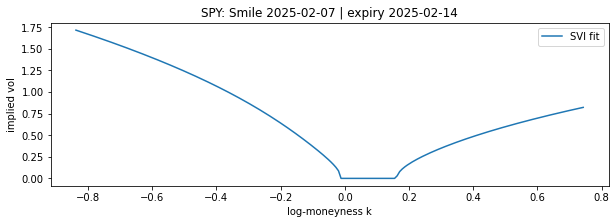

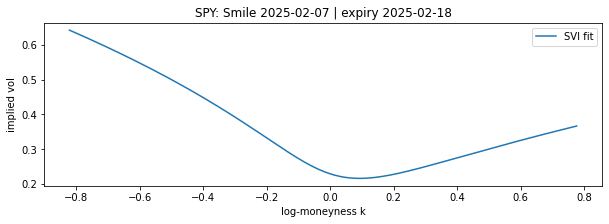

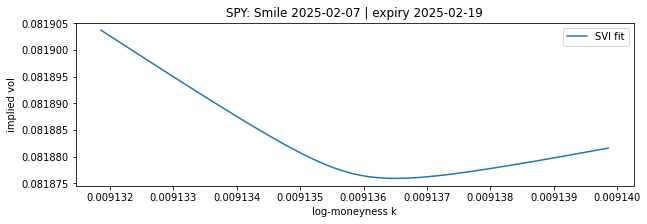

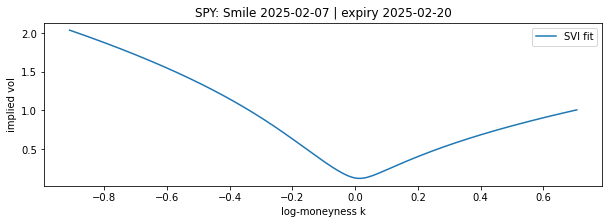

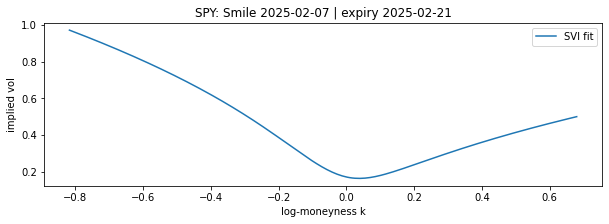

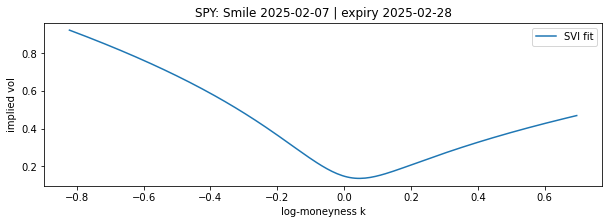

In [5]:
def plot_smiles(chain_all, chain_mkt, params_by_exp, max_exps=6, k_pad=4.0):
    exps = sorted(params_by_exp.keys())[:max_exps]

    for exp in exps:
        sub_all = chain_all[chain_all["expiry"] == exp]
        if sub_all.empty:
            continue

        # --- get SVI params ---
        a,b,rho,m,sig = params_by_exp[exp]
        T = float(svi_df.loc[svi_df["expiry"]==exp, "T"].iloc[0])

        # --- use a wider grid than observed k-range ---
        k_lo = m - k_pad*sig
        k_hi = m + k_pad*sig

        # fallback if sig is tiny / degenerate
        if not np.isfinite(k_lo) or not np.isfinite(k_hi) or k_lo >= k_hi:
            k_lo, k_hi = -0.25, 0.25

        k_grid = np.linspace(k_lo, k_hi, 200)
        iv_fit = svi_iv(k_grid, T, params_by_exp[exp])

        plt.figure(figsize=(10,3))

        sub_mkt = chain_mkt[chain_mkt["expiry"]==exp]
        if not sub_mkt.empty:
            plt.scatter(sub_mkt["k"], sub_mkt["iv_fit"], s=12, label="market")

        plt.plot(k_grid, iv_fit, label="SVI fit")
        plt.title(f"SPY: Smile {AS_OF} | expiry {exp.date()}")
        plt.xlabel("log-moneyness k")
        plt.ylabel("implied vol")
        plt.legend()
        plt.show()


plot_smiles(chain_all, chain_mkt, params_by_exp)

We plot against log-moneyness $k=\ln(K/F)$, so:

- $k<0$ corresponds to **OTM puts / downside protection** (left wing),
- $k\approx 0$ is **ATM**,
- $k>0$ corresponds to **OTM calls** (right wing).

In equity index options you expect a **“smirk”**: higher IV on the left wing than the right wing, reflecting persistent crash-risk pricing.The plots are telling us:

1. **Strong downside skew across expiries.**  On every date, implied vol rises sharply for negative $k$. This is the canonical SPY/SPX pattern: investors pay up for downside insurance, so OTM puts trade at materially higher vol than ATM or OTM calls. This is known as **crash-risk hedging demand** indicating investors’ willingness to pay up for protection against sudden market drawdowns. Large fund managers (long-only, pensions, structured-product dealers, risk-parity, etc.) often buy out-of-the-money index puts to limit tail losses and meet risk/VaR constraints. When many do this at once, OTM puts become expensive, so left-tail implied vols rise and the smile develops a steeper negative skew. In other words, a pronounced left wing in SPY/SPX smiles is the market’s price tag on downside insurance.

2. **SVI is behaving as expected.**  Even when market points are sparse, the fitted curve produces a smooth, stable smile with:
   - high left-tail vol,
   - a flatter ATM region,
   - and (sometimes) a mild rebound on the far right wing.  
   That shape is exactly what we need for a surface that can be differentiated/integrated and checked for static arbitrage.

3. **Wing outliers are present (and are expected with EOD closes).**  A few maturities show single points far away from the rest of the smile (e.g., very high left-wing vols or occasional low-vol “strays”).  
   These are almost always microstructure artifacts: illiquid strikes, stale EOD prints, or parity noise.  

4. **Right-wing information is sometimes thin.**  Some dates (e.g., 11-12 not shown here) have little or no positive-$k$ coverage, so the fitted right wing is effectively an extrapolation guided by SVI regularity.  
   In practice, desks accept this but monitor it — it’s why production fits often use bid/ask mids and vega-weighted calibration.

The smiles look *economically correct* for SPY, and the SVI layer is doing what a desk fit should do — smoothing noisy discrete quotes into a coherent per-expiry smile while down-weighting unreliable wing prints. In a production build, the next incremental upgrades would be bid/ask mids, vega weights, and explicit wing constraints, but as a GitHub case study this is already a credible surface diagnostic for us!

## 5. Surface reconstruction and ATM term structure

Having validated individual smiles, we now assemble a **coherent implied-volatility surface** across log-moneyness $k$ and maturity $T$, entirely from the SVI fits.

### 5.1 Build a common $k$ grid across expiries

To compare smiles across maturities, we evaluate every expiry on a shared log-moneyness grid $k_{\text{common}}$.

- If the chain provides a reasonable $k$ span, we use:

  $$
  k_{\min} = \min k,\qquad k_{\max} = \max k.
  $$

- If market IV inversion was sparse or failed (so $k$ coverage is unreliable), we fall back to an SVI-based range using the calibrated centers $m$ and curvatures $\sigma$:

  $$
  k_{\min} = \min(m - 4\sigma),\qquad
  k_{\max} = \max(m + 4\sigma).
  $$

This ensures the surface remains stable even with thin EOD chains.

### 5.2 Evaluate fitted IV surface on $(k,T)$

For each expiry with maturity $T_i$, we compute total variance from SVI:

$$
w(k,T_i)=a_i + b_i\left(\rho_i (k-m_i) + \sqrt{(k-m_i)^2+\sigma_i^2}\right),
$$

and convert to fitted implied volatility:

$$
\mathrm{IV}_{SVI}(k,T_i)=\sqrt{\frac{w(k,T_i)}{T_i}}.
$$

Stacking these slices across expiries yields an implied-vol matrix
$\mathrm{IV}(k_{\text{common}},T_i)$, which we visualize as a heatmap.  
This is the fitted equity vol surface for the chosen as-of date.

### 5.3 Extract ATM term structure

To obtain a desk-standard ATM term structure, we identify the grid point closest to $k=0$:

$$
k_{\text{ATM}} \approx 0,
$$

and read off fitted ATM vols for each maturity:

$$
\mathrm{ATM\_IV}(T_i) = \mathrm{IV}_{SVI}(k_{\text{ATM}},T_i).
$$

Plotting $\mathrm{ATM\_IV}(T_i)$ against $T_i$ gives a clean term-structure view of equity vol, suitable for:

- comparing regimes across dates,
- calibrating simple parametric term-structure models,
- or feeding QIS strategies that depend on variance levels by horizon.

The final table reports $(\text{expiry}, T, \mathrm{ATM\_IV})$ for downstream analysis.


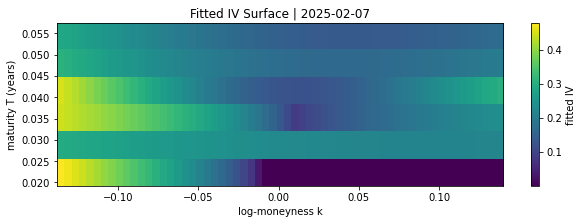

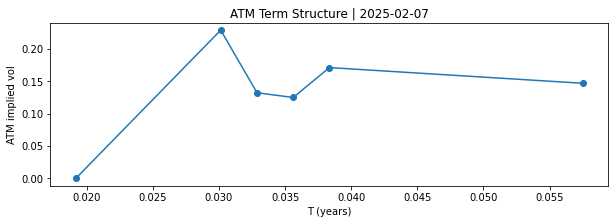

,expiry,T,ATM_IV
0,2025-02-14,0.019178,0.000007
1,2025-02-18,0.030137,0.228549
2,2025-02-19,0.032877,0.132045
3,2025-02-20,0.035616,0.124738
4,2025-02-21,0.038356,0.170807
5,2025-02-28,0.057534,0.146599


In [6]:
def surface_grid(chain_all, params_by_exp, nk=61):
    # k-range from full chain; if strange, fallback to SVI m±4sig
    if chain_all.empty or not np.isfinite(chain_all["k"].min()):
        m_vals = svi_df["m"].to_numpy(float)
        sig_vals = svi_df["sig"].to_numpy(float)
        k_lo = float(np.min(m_vals - 4*sig_vals))
        k_hi = float(np.max(m_vals + 4*sig_vals))
        if not np.isfinite(k_lo) or not np.isfinite(k_hi) or k_lo==k_hi:
            k_lo, k_hi = -0.25, 0.25
    else:
        k_lo, k_hi = float(chain_all["k"].min()), float(chain_all["k"].max())

    k_common = np.linspace(k_lo, k_hi, nk)
    exps = sorted(params_by_exp.keys())
    Ts, iv_mat = [], []

    for exp in exps:
        T = float(svi_df.loc[svi_df["expiry"]==exp, "T"].iloc[0])
        Ts.append(T)
        iv_mat.append(svi_iv(k_common, T, params_by_exp[exp]))

    Ts = np.array(Ts)
    iv_mat = np.vstack(iv_mat)
    return k_common, Ts, iv_mat, exps

k_common, Ts, iv_mat, exps = surface_grid(chain_all, params_by_exp)

plt.figure(figsize=(10,3))
plt.imshow(iv_mat, aspect="auto", origin="lower",
           extent=[k_common.min(), k_common.max(), Ts.min(), Ts.max()])
plt.colorbar(label="fitted IV")
plt.title(f"Fitted IV Surface | {AS_OF}")
plt.xlabel("log‑moneyness k")
plt.ylabel("maturity T (years)")
plt.show()

atm_idx = np.argmin(np.abs(k_common))
atm_iv = iv_mat[:, atm_idx]

plt.figure(figsize=(10,3))
plt.plot(Ts, atm_iv, marker="o")
plt.title(f"ATM Term Structure | {AS_OF}")
plt.xlabel("T (years)")
plt.ylabel("ATM implied vol")
plt.show()

pd.DataFrame({"expiry": exps, "T": Ts, "ATM_IV": atm_iv})

## 5.4 Smile skew and convexity term structures (local features)

Beyond ATM level, desks often monitor **smile shape** through two simple local features:

1. **Skew** (slope of IV vs log-moneyness near ATM)  
2. **Convexity** (curvature around ATM)

Using the fitted surface $\mathrm{IV}(k,T)$ on the common grid, we approximate these features for each maturity $T_i$ by taking symmetric points around ATM.

### Local skew

Let $k_{\text{ATM}} \approx 0$, and choose two nearby points  
$k_- = k_{\text{ATM}}-\Delta k$ and $k_+ = k_{\text{ATM}}+\Delta k$.  
A finite-difference approximation to skew is:

$$
\text{Skew}(T_i) \approx \frac{\mathrm{IV}(k_-,T_i)-\mathrm{IV}(k_+,T_i)}{k_+ - k_-}
\;\; \approx \;\; \left.\frac{\partial \mathrm{IV}(k,T_i)}{\partial k}\right|_{k\approx 0}.
$$

In the code, $\Delta k$ corresponds to about 5 grid steps on each side.

### Local convexity

A simple curvature proxy is the discrete second-difference:

$$
\text{Convexity}(T_i) \approx \mathrm{IV}(k_-,T_i)+\mathrm{IV}(k_+,T_i)
-2\,\mathrm{IV}(k_{\text{ATM}},T_i)
\;\; \propto \;\;
\left.\frac{\partial^2 \mathrm{IV}(k,T_i)}{\partial k^2}\right|_{k\approx 0}.
$$

Positive convexity indicates a pronounced “smile,” while near-zero convexity suggests a flatter local shape.

### Output

We assemble a term-structure table with, for each expiry:

- maturity $T$
- fitted ATM IV
- local skew
- local convexity

These features are standard inputs to equity-vol QIS signals (e.g., skew carry, convexity regime filters) and help interpret how the surface evolves with horizon.


In [7]:
# --- Simple skew/convexity diagnostics ---
def feature_table(k_common, Ts, iv_mat):
    atm_idx = np.argmin(np.abs(k_common))
    k_dn = k_common[atm_idx-5] if atm_idx-5 >= 0 else k_common[0]
    k_up = k_common[atm_idx+5] if atm_idx+5 < len(k_common) else k_common[-1]

    dn_idx = np.argmin(np.abs(k_common - k_dn))
    up_idx = np.argmin(np.abs(k_common - k_up))

    atm = iv_mat[:, atm_idx]
    skew = (iv_mat[:, dn_idx] - iv_mat[:, up_idx]) / (k_up - k_dn)   # slope
    convex = iv_mat[:, dn_idx] + iv_mat[:, up_idx] - 2*atm          # curvature

    return pd.DataFrame({
        "expiry": exps,
        "T": Ts,
        "ATM_IV": atm,
        "Skew(dIV/dk)": skew,
        "Convexity": convex
    })

feat_df = feature_table(k_common, Ts, iv_mat)
feat_df


,expiry,T,ATM_IV,Skew(dIV/dk),Convexity
0,2025-02-14,0.019178,0.000007,2.212856,0.102584
1,2025-02-18,0.030137,0.228549,0.292412,0.001799
2,2025-02-19,0.032877,0.132045,2.290727,0.064583
3,2025-02-20,0.035616,0.124738,0.657566,0.026328
4,2025-02-21,0.038356,0.170807,0.403092,0.005917
5,2025-02-28,0.057534,0.146599,0.502077,0.005903


### Skew term structure plot

We visualize the maturity profile of local skew by plotting $\text{Skew}(T)$ against $T$.

This is a compact desk diagnostic:  

- **Negative skew** (downside vols higher than upside vols) is typical in equities and reflects crash-risk premium.  
- The **shape across maturities** indicates where skew risk is concentrated:
  - steep front-end skew often signals near-term tail risk or event premium,
  - flatter long-end skew suggests more symmetric long-horizon expectations.

Formally, the plotted quantity is the finite-difference proxy

$$
\text{Skew}(T_i) \approx \frac{\mathrm{IV}(k_-,T_i)-\mathrm{IV}(k_+,T_i)}{k_+-k_-},
$$

evaluated around ATM for each maturity.  

Interpreting this curve alongside ATM IV and convexity provides a quick read on whether the market is pricing **level**, **asymmetry**, or **curvature** risk at different horizons.


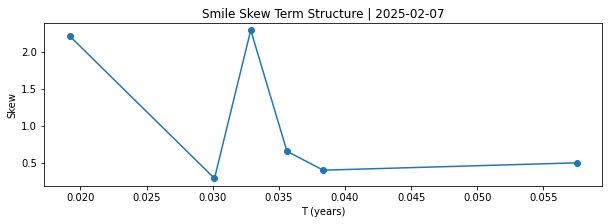

In [8]:
plt.figure(figsize=(10,3))
plt.plot(feat_df["T"], feat_df["Skew(dIV/dk)"], marker="o")
plt.title(f"Smile Skew Term Structure | {AS_OF}")
plt.xlabel("T (years)")
plt.ylabel("Skew")
plt.show()


## 6. Diagnostics

In [9]:
def calendar_violations(k_common, exps, params_by_exp):
    ws = np.vstack([svi_raw(k_common, *params_by_exp[e]) for e in exps])
    return int((np.diff(ws, axis=0) < -1e-6).sum())

def min_total_variance(k_common, exps, params_by_exp):
    return np.array([svi_raw(k_common, *params_by_exp[e]).min() for e in exps])

cal_viol = calendar_violations(k_common, exps, params_by_exp)
w_mins = min_total_variance(k_common, exps, params_by_exp)

print("Calendar violations:", cal_viol)
pd.DataFrame({"expiry": exps, "min_w": w_mins})

Calendar violations: 101


,expiry,min_w
0,2025-02-14,-0.000655
1,2025-02-18,0.001401
2,2025-02-19,0.000232
3,2025-02-20,0.000514
4,2025-02-21,0.001024
5,2025-02-28,0.001055


## 7. Desk use case: variance swap fair strike (proxy)

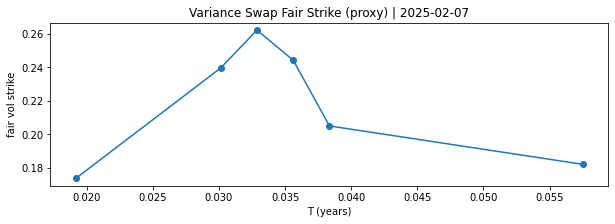

,expiry,T,var_fair,vol_fair
0,2025-02-14,0.019178,0.030213,0.173820
1,2025-02-18,0.030137,0.057427,0.239639
2,2025-02-19,0.032877,0.068744,0.262190
3,2025-02-20,0.035616,0.059653,0.244240
4,2025-02-21,0.038356,0.042061,0.205087
5,2025-02-28,0.057534,0.033189,0.182179


In [10]:
def variance_swap_fair_strike(k_common, T, params):
    w = svi_raw(k_common, *params)
    avg_w = np.trapz(w, k_common) / (k_common.max() - k_common.min())
    return float(avg_w / T)

vs_var = np.array([variance_swap_fair_strike(k_common, T, params_by_exp[e])
                   for e, T in zip(exps, Ts)])
vs_vol = np.sqrt(np.maximum(vs_var, 0))

plt.figure(figsize=(10,3))
plt.plot(Ts, vs_vol, marker="o")
plt.title(f"Variance Swap Fair Strike (proxy) | {AS_OF}")
plt.xlabel("T (years)")
plt.ylabel("fair vol strike")
plt.show()

pd.DataFrame({"expiry": exps, "T": Ts, "var_fair": vs_var, "vol_fair": vs_vol})

In [11]:
def make_summary():
    return pd.Series({
        "As-of date": AS_OF,
        "Expiries fitted": len(params_by_exp),
        "Chain rows (raw)": len(chain_raw),
        "Chain rows w/ IV": len(chain_mkt),
        "k-range used": (float(k_common.min()), float(k_common.max())),
        "Calendar violations": cal_viol,
        "Min total variance (worst expiry)": float(w_mins.min()),
        "ATM IV (front, back)": (float(atm_iv[0]), float(atm_iv[-1])),
        "VS fair vol (front, back)": (float(vs_vol[0]), float(vs_vol[-1])),
    })

# see the end of the notebook:
# make_summary()


In [12]:
make_summary()

As-of date                                                            2025-02-07
Expiries fitted                                                                6
Chain rows (raw)                                                             156
Chain rows w/ IV                                                               0
k-range used                         (-0.13827579516258967, 0.13987399347057475)
Calendar violations                                                          101
Min total variance (worst expiry)                                      -0.000655
ATM IV (front, back)                 (7.221001117771492e-06, 0.1465988118266396)
VS fair vol (front, back)              (0.1738196275514007, 0.18217869637577486)
dtype: object